# Let's build GPT: from scratch, in code, spelled out

https://www.youtube.com/watch?v=kCc8FmEb1nY

GitHub repo: https://github.com/karpathy/ng-video-lecture

Goal of this final lecture is to create our own GPT. ChatGPT itself is a language model finishing input we provide. What's happening under the hood, modeling the sequence of words?

Generatively Pretrained Transformer - transformers come from 2017 paper [Attention is all you need](https://arxiv.org/abs/1706.03762)

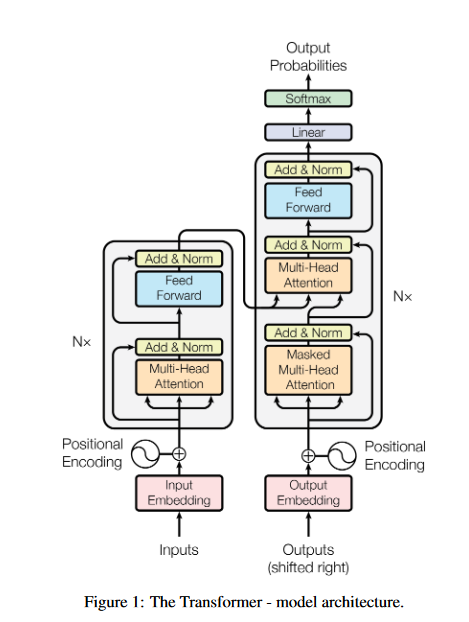

# Data and setup

Goal: train our own character-level data model using the complete works of Shakespeare (~1MB). Given some context, the transformer will look at a set of sequences and try to figure out what comes next.

Starter code contains 2 files, one defining the GPT architecture, and 1 training it.

In [1]:
# Read in the starting dataset

with open('ng-video-lecture/input.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


This is an ordered list of characters in the dataset; the entire set has 65 characters, starting with space, special characters, and then capitals and lowercase.

Need to tokenize the input text to an integer sequence that contains the vocabulary.

In [5]:
# create a mapping from characters to integers
# Simply iterates over character tablee printed above
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


More advanced tokenizers include e.g. SentencePiece which encodes sub-words and OpenAI uses tiktoken (used by their GPT). Have many more possible tokens; bigger codebook size for smaller sequence lengths. We'll use a simple character-level one with a small codebook for practice, resulting in long sequences.

In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

This just translates the dataset of text into a long sequence of integers. First 90% is the training data.

In [8]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


As before we'll set a block size, and train in batches. Recall that we'll train all the examples in the block at once. We get 8 training examples from the 8 character block, and 9th target. This gives the transformers the ability to predict with different levels of context, up to block_size.

Adding batches:

In [10]:
torch.manual_seed(1337) # for reproducibility
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # random offsets into the training set
    x = torch.stack([data[i:i+block_size] for i in ix]) # 
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [11]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


4 x 8 array contains 32 training examples. They're independent as far as the training process is concerned.

# Bigram model

Simplest version of a model would be to just use bigrams, as we did in the first lecture. Implementing directly in PyTorch:

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

# Take indices idx and pass them into the token embedding table
# Every integer refers to embedding table
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        return logits
    
m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

torch.Size([4, 8, 65])


(B, T, C) = (4 = batch size, 8 = block size, 65 = vocab size)

Add definitions for loss.

`loss = F.cross_entropy(logits, targets)` won't work; need to specify the dimensionality

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

# Take indices idx and pass them into the token embedding table
# Every integer refers to embedding table
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        # loss = F.cross_entropy(logits, targets) won't work; need to specify the dimensionality
        B, T, C = logits.shape
        logits = logits.view(B*T, C) # stretches out tensor to 2D from 3D
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

        return logits, loss
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


Higher loss than before which isn't surprising given a larger vocab size. Expected loss on an untrained model is:

$ -ln(1/65) \approx 4.17 $

So we have bad initial predictions but the loss evaluation function works.

Last piece is a model generation function.

In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# start with zeros tensor (newline in this case) to kick off generator
idx = torch.zeros((1, 1), dtype=torch.long)
# generate max of 100 tokens
max_new_tokens=100
# index to [0] row to "unplug" single batch dimension, then feed it to a list and pass to decode function we created
print(decode(m.generate(idx, max_new_tokens)[0].tolist()))

torch.Size([256, 65])
tensor(4.7082, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


This is nonsense because the model isn't yet trained. That's the next step.

The code is very inefficient for a bigram model (why look at previous context when only 1 letter is used for prediction) but this will be used for the more complex model.

Create a PyTorch optimizer using AdamW, better than SGD.

In [27]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [28]:
batch_size = 32
for steps in range(100): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    print(loss.item())


4.704006195068359
4.721118927001953
4.653193473815918
4.706261157989502
4.780904293060303
4.751267910003662
4.8395490646362305
4.667973041534424
4.743716716766357
4.774043083190918
4.6908278465271
4.789142608642578
4.61777925491333
4.650947093963623
4.886447429656982
4.703796863555908
4.757591724395752
4.65510892868042
4.709283828735352
4.6745147705078125
4.760501384735107
4.7892632484436035
4.653748512268066
4.6619181632995605
4.673007488250732
4.66577672958374
4.7301106452941895
4.755304336547852
4.712186813354492
4.745501518249512
4.726755619049072
4.735108375549316
4.777461051940918
4.643350601196289
4.6651835441589355
4.79764461517334
4.717412948608398
4.683647155761719
4.81886100769043
4.613771915435791
4.573785781860352
4.560741901397705
4.81563138961792
4.6061553955078125
4.619696140289307
4.725419521331787
4.650487899780273
4.5941481590271
4.7202863693237305
4.699342250823975
4.6724138259887695
4.727972984313965
4.66152286529541
4.616766929626465
4.599857807159424
4.6533403396

Clearly something is happening - loss went down noticeably in the first 100 iterations.

Try more training, in batches of 1000.

In [29]:
batch_size = 32

for _ in range(10):
    for steps in range(1000): # increase number of steps for good results... 
        
        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = m(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    print(loss.item())


3.6380467414855957
3.108039617538452
2.8381078243255615
2.7120282649993896
2.4290480613708496
2.385906219482422
2.4341988563537598
2.3517560958862305
2.594815731048584
2.4522740840911865


Mid 2 range is about where the original bigram model was. Output should look less random.

In [30]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


DUKIVisun Casshe wisthiot s.
LUK:

NGOLI io e alllker s?j$NCowens l het hislaspicobar, heay ind, cigigeluandac! thaforo nont
SLO:
Ange ive nn I ou m,
UCENTheanp'Lbet bazzl
TEEXNore t b'Thathon:
sous min'd ne st wousis s lingilo whee,
K:
Toow'e's,
D:
NGLEng, do te! ase may sin ceecate.
God? d
Aw ht hongur vet ouley, tonches s ousour mes o be angaxHatiminthafe atnt ur whis heand ay out sitourdy spehacugnting akefo tofed werore mo d htreldeg ise se inon ime weagsone the kener bs s oweclishentens t 


Yeah, definitely starting to look more Shakespeare though still not good.

# Scripted training

Next step: convert bigram model to a script, `bigram.py` (taken from github repo).

Uses various speed-up tricks, like doing training on cuda cores if available, which will be much faster. Also torch.no_grad() and giving context like setting model.train() and model.test() where appropriate.

# Self-attention

In [49]:
# consider the following toy example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

We want to have the up to 8 tokens in a batch to be coupled and "talk" to each other. 5th location token should see 1-4 but not 6-8. Information flows form previous to current timeslot.

Simplest way to get past info is take an "average" of vectors of previous tokens, and this one.

In [50]:
# We want x[b,t] = mean_{i<=t} x[b,i]
# bow = bag of words
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [51]:
print(x[0])
print(xbow[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


Note in 2nd tensor, each subsequent row is average of the preceding ones. It works but is inefficient.

Instead, let's use matrix multiplication - much faster.

In [52]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
# torch.tril is the lower triangular part of the matrix
# [[1,0,0],[1,1,0],[1,1,1]]
a = torch.tril(torch.ones(3, 3))
# Normalize all rows so they sum to 1
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Note that the first row of $a$ returns 1st element, 2nd row is average of first 2, third row is average of all 3, etc.

Implementing:

In [55]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
# wei is (T, T) but gets B appended due to dimensionality of x
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

print(xbow[0])
print(xbow2[0])

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


Another version: use softmax.

wei starts as all 0; what masked_fill does is make all 0 elements -inf. Taking softmax along every row, we get same matrix.

In [57]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

In [58]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


The softmax version is what we'll actually use for self attention. Start with 0, and the -inf says don't look at the future. Softmax will allow values to change so previous elements are more or less interesting to one another; not just a straight average.

Final version: don't initialize weights to be all 0. Similar rationale to weight initialization for other NN models. Want information to flow based on the data, e.g. if there's a vowel maybe consonants should be higher weighted.

Self-attention solves this: each node emits two vectors: query, and key. Query vbector is "what's being looked for" and key vector is "what's contained" - do dot product between keys and queries to create new weights.

In [60]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# Dot product between queries and keys
# Every row of B has a TxT matrix of the affinities
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei replaced by the dot product above
#wei = torch.zeros((T,T))
# This step ensures "future" information doesn't leak
wei = wei.masked_fill(tril == 0, float('-inf'))
# This normalizes the row
wei = F.softmax(wei, dim=-1)

# Don't use raw x, aggregate to v
v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [62]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Now each batch element has its own tokens for wei. The weights are no longer uniform; each token has their own query and the matrices get updated during training.

Conceptually attention is a directed graph - passing information between nodes. Our graph would have loops, with 1 pointing to itself, 2 pointed to by 1 and 2, etc. but in principle attention supports arbitrarily connected graphs.

From Andrej's notes:

*    Attention is a communication mechanism. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
*    There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
*    Each example across batch dimension is of course processed completely independently and never "talk" to each other
*    In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
*    "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
*    "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [65]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
# -sqrt(head_size) is the correction
wei = q @ k.transpose(-2, -1) * head_size**-0.5

print("head size =", head_size)
print((q @ k.transpose(-2, -1)).var())
print(wei.var())

head size =  16
tensor(16.1036)
tensor(1.0065)


Note without the correction factor of $\frac{1}{\sqrt{headsize}}$ the variance is proportional to `head_size` and i0t's important to initialize wei near 0 since there's a softmax. We don't want particularly extreme values because they get pushed to -1 or 1 by softmax; same issue seen initializing parameters in other networks.

See `Head` class in gpt.py for implementation. In the language model the head is created by the constructor.

# Self-attention model

Train a model with the new elements.

In [89]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        #wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa_head(x) # apply one head of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.2000, val loss 4.2047
step 500: train loss 2.6911, val loss 2.7087
step 1000: train loss 2.5196, val loss 2.5303
step 1500: train loss 2.4775, val loss 2.4829
step 2000: train loss 2.4408, val loss 2.4523
step 2500: train loss 2.4272, val loss 2.4435
step 3000: train loss 2.4130, val loss 2.4327
step 3500: train loss 2.3956, val loss 2.4212
step 4000: train loss 2.4041, val loss 2.3992
step 4500: train loss 2.3980, val loss 2.4084


In [90]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Wes le isen.
Woto teven INGO, ous into CYedd shou maithe ert thethens the the del ede cksy ow? Wlouby aicecat tisall wor
G'imemonou mar ee hacreancad hontrt had wousk ucavere.

Baraghe lfousto beme,
S m; ten gh;
S:
Ano ice de bay alysathef beatireplim serbeais I fard
Sy,
Me hallil:
DWAR: us,
Wte hse aecathate, parrise in hr'd pat
ERY:
Bf bul walde betl'ts I yshore grest atre ciak aloo; wo fart hets atl.

That at Wh kear ben.
 hend.

KTh'd foushe d'l otacaengs p bloul blod arme foot buthes fo boe


Small but apparent improvement from before. Next step is multi-head attention, mutliple heads in parallel.

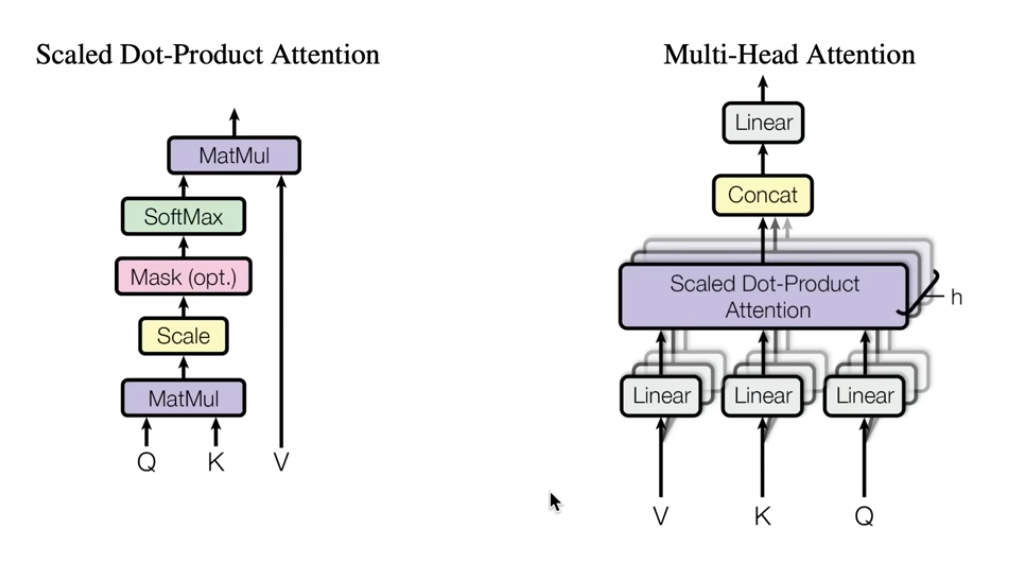

In [91]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim = -1)

Instead of 1 communication channel there are now 4 in parallel, 8 dimensional heads of self-attention.

Apparently similar to group convolution.

In [92]:
torch.manual_seed(1337)

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa_heads(x) # apply one head of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2227, val loss 4.2226
step 500: train loss 2.6592, val loss 2.6733
step 1000: train loss 2.4980, val loss 2.5064
step 1500: train loss 2.4291, val loss 2.4349
step 2000: train loss 2.3716, val loss 2.3844
step 2500: train loss 2.3417, val loss 2.3561
step 3000: train loss 2.3149, val loss 2.3347
step 3500: train loss 2.2918, val loss 2.3171
step 4000: train loss 2.2895, val loss 2.2868
step 4500: train loss 2.2748, val loss 2.2858


In [93]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


We! le ises.
Wmay they row we thutinte Caldd shou mait tiertlentthens the the dol ede cksy ba? Wlouby arceckentisste wre
G'imemonot mar ef hacr
COngd Go mringt thouskiu?

Fre.

Bardageplftisto be ess the to hon;
Soretr ice we bay, Thouthe wome isspe, laveberis I fald
Sy,
Whissitill there git; the se aTist,
Anos arrise in wito pat
ER:
Tuche'l walde,
Anl'th I yourre grest at west ont of; wonf Gost theatl.

That Ongss to habe to hend.

KTh'd forshe do- of warngs pis ond blou arout: o ce ther fo boe


Passed the 2.3 validation mark. Having multiple channels helps because there's lots of communication that can be used by the tokens: consonants, vowels, strings of consonants, etc. Helps to have more types of data and decoding the output.